In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, division

import os
import sys
sys.path.append("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
import json
import importlib
from glob import glob
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torch.optim import Adam, SGD
from losses import DiceLoss, DiceLossWithLogtis
from torch.nn import BCELoss, CrossEntropyLoss

from utils import (
    show_image_and_mask,
    load_config,
    _print,
)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#torch.manual_seed(0)
#np.random.seed(0)
#torch.cuda.manual_seed(0)
#import random
#random.seed(0)

In [4]:
CONFIG_NAME = "nuclei_denseunet.yaml"
CONFIG_FILE_PATH = os.path.join("../configs", CONFIG_NAME)

In [5]:
config = load_config(CONFIG_FILE_PATH)
_print("Config:", "info_underline")
print(json.dumps(config, indent=2))
print(20*"~-", "\n")

Config:
{
  "run": {
    "mode": "train",
    "device": "gpu"
  },
  "transforms": "none",
  "dataset": {
    "class_name": "nuclei_dataset",
    "input_size": 224,
    "data_dir": "/home/gmahalingam/My.Explorations/datasets/data-science-bowl-2018/data",
    "training": {
      "params": {
        "data_dir": "/home/gmahalingam/My.Explorations/datasets/data-science-bowl-2018/data"
      }
    },
    "validation": {
      "params": {
        "data_dir": "/home/gmahalingam/My.Explorations/datasets/data-science-bowl-2018/data"
      }
    },
    "number_classes": 2
  },
  "data_loader": {
    "train": {
      "batch_size": 4,
      "shuffle": true,
      "num_workers": 8,
      "pin_memory": true
    },
    "validation": {
      "batch_size": 4,
      "shuffle": false,
      "num_workers": 8,
      "pin_memory": true
    },
    "test": {
      "batch_size": 2,
      "shuffle": false,
      "num_workers": 4,
      "pin_memory": false
    }
  },
  "training": {
    "optimizer": {
      "nam

In [6]:
from datasets.nuclei_dataset import nuclei_dataset
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [7]:
INPUT_SIZE = config['dataset']['input_size']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")



Torch device: cuda


In [8]:
def prepare_datasets(config):
    data_path = config['dataset']['data_dir']
    train_dataset = nuclei_dataset(data_path, mode="train", one_hot=True)
    val_dataset = nuclei_dataset(data_path, mode="val", one_hot=True)
    test_dataset = nuclei_dataset(data_path, mode="test", one_hot=True)

    tr_datalodaer = DataLoader(train_dataset, **config['data_loader']['train'])
    val_dataloader = DataLoader(val_dataset, **config['data_loader']['validation'])
    test_dataloader = DataLoader(test_dataset, **config['data_loader']['test'])

    return tr_datalodaer, val_dataloader, test_dataloader

In [9]:
train_dataloader, val_dataloader, test_dataloader = prepare_datasets(config)

In [10]:
metrics = torchmetrics.MetricCollection(
    [
        torchmetrics.F1Score(task="multiclass", num_classes=2),
        torchmetrics.Accuracy(task="multiclass", num_classes=2),
        torchmetrics.Dice(),
        torchmetrics.Precision(task="multiclass", num_classes=2),
        torchmetrics.Specificity(task="multiclass", num_classes=2),
        torchmetrics.Recall(task="multiclass", num_classes=2),
        # IoU
        torchmetrics.JaccardIndex(task="multiclass", num_classes=2)
    ],
    prefix='train_metrics/'
)

# train_metrics
train_metrics = metrics.clone(prefix='train_metrics/').to(device)

# valid_metrics
valid_metrics = metrics.clone(prefix='valid_metrics/').to(device)

# test_metrics
test_metrics = metrics.clone(prefix='test_metrics/').to(device)

In [11]:
def make_serializeable_metrics(computed_metrics):
    res = {}
    for k, v in computed_metrics.items():
        res[k] = float(v.cpu().detach().numpy())
    return res

In [12]:
def validate(model, criterion, vl_dataloader):
    model.eval()
    with torch.no_grad():
        
        evaluator = valid_metrics.clone().to(device)
        
        losses = []
        cnt = 0.
        for batch, batch_data in enumerate(vl_dataloader):
            imgs = batch_data['image']
            msks = batch_data['mask']
            
            cnt += msks.shape[0]
            
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            preds = model(imgs)
            loss = criterion(preds, msks)
            losses.append(loss.item())
            
            
            preds_ = torch.argmax(preds, 1, keepdim=False).float()
            msks_ = torch.argmax(msks, 1, keepdim=False)
            evaluator.update(preds_, msks_)
        
#             _cml = f"curr_mean-loss:{np.sum(losses)/cnt:0.5f}"
#             _bl = f"batch-loss:{losses[-1]/msks.shape[0]:0.5f}"
#             iterator.set_description(f"Validation) batch:{batch+1:04d} -> {_cml}, {_bl}")
        
        # print the final results
        loss = np.sum(losses)/cnt
        metrics = evaluator.compute()
    
    return evaluator, loss

In [13]:
def train(
    model, 
    device, 
    tr_dataloader,
    vl_dataloader,
    config,
    
    criterion,
    optimizer,
    scheduler,
    
    save_dir='./',
    save_file_id=None,
):
    
    EPOCHS = config['training']['epochs']
    
    torch.cuda.empty_cache()
    model = model.to(device)

    evaluator = train_metrics.clone().to(device)
    
    epochs_info = []
    best_model = None
    best_result = {}
    best_vl_loss = np.Inf
    for epoch in range(EPOCHS):
        model.train()
        
        evaluator.reset()
        tr_iterator = tqdm(enumerate(tr_dataloader))
        tr_losses = []
        cnt = 0
        for batch, batch_data in tr_iterator:
            imgs = batch_data['image']
            msks = batch_data['mask']
            
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, msks)
            loss.backward()
            optimizer.step()
            
            # evaluate by metrics
            preds_ = torch.argmax(preds, 1, keepdim=False).float()
            msks_ = torch.argmax(msks, 1, keepdim=False)
            evaluator.update(preds_, msks_)
            
            cnt += imgs.shape[0]
            tr_losses.append(loss.item())
            
            # write details for each training batch
            _cml = f"curr_mean-loss:{np.sum(tr_losses)/cnt:0.5f}"
            _bl = f"mean_batch-loss:{tr_losses[-1]/imgs.shape[0]:0.5f}"
            tr_iterator.set_description(f"Training) ep:{epoch:03d}, batch:{batch+1:04d} -> {_cml}, {_bl}")
            
        tr_loss = np.sum(tr_losses)/cnt
        
        # validate model
        vl_metrics, vl_loss = validate(model, criterion, vl_dataloader)
        if vl_loss < best_vl_loss:
            # find a better model
            best_model = model
            best_vl_loss = vl_loss
            best_result = {
                'tr_loss': tr_loss,
                'vl_loss': vl_loss,
                'tr_metrics': make_serializeable_metrics(evaluator.compute()),
                'vl_metrics': make_serializeable_metrics(vl_metrics.compute())
            }
        
        # write the final results
        epoch_info = {
            'tr_loss': tr_loss,
            'vl_loss': vl_loss,
            'tr_metrics': make_serializeable_metrics(evaluator.compute()),
            'vl_metrics': make_serializeable_metrics(vl_metrics.compute())
        }
        epochs_info.append(epoch_info)
#         epoch_tqdm.set_description(f"Epoch:{epoch+1}/{EPOCHS} -> tr_loss:{tr_loss}, vl_loss:{vl_loss}")
        evaluator.reset()
    
        scheduler.step(vl_loss)
  
    # save final results
    res = {
        'id': save_file_id,
        'config': config,
        'epochs_info': epochs_info,
        'best_result': best_result
    }
    fn = f"{save_file_id+'_' if save_file_id else ''}result.json"
    fp = os.path.join(config['model']['save_dir'],fn)
    with open(fp, "w") as write_file:
        json.dump(res, write_file, indent=4)

    # save model's state_dict
    fn = "last_model_state_dict.pt"
    fp = os.path.join(config['model']['save_dir'],fn)
    torch.save(model.state_dict(), fp)
    
    # save the best model's state_dict
    fn = "best_model_state_dict.pt"
    fp = os.path.join(config['model']['save_dir'], fn)
    torch.save(best_model.state_dict(), fp)
    
    return best_model, model, res

In [14]:
def test(model, te_dataloader):
    model.eval()
    with torch.no_grad():
        evaluator = test_metrics.clone().to(device)            
        for batch_data in tqdm(te_dataloader):
            imgs = batch_data['image']
            msks = batch_data['mask']
            
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            preds = model(imgs)
            
            # evaluate by metrics
            preds_ = torch.argmax(preds, 1, keepdim=False).float()
            msks_ = torch.argmax(msks, 1, keepdim=False)
            evaluator.update(preds_, msks_)
            
    return evaluator

In [15]:
from models.dense_unet import DenseUNet as Net 

model = Net(config['model']['params']['n_classes'], downsample=True)

torch.cuda.empty_cache()
model = model.to(device)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/model_state_dict.pt"

if config['model']['load_weights']:
    model.load_state_dict(torch.load(model_path))
    print("Loaded pre-trained weights...")
    
    
# criterion_dice = DiceLoss()
criterion_dice = DiceLossWithLogtis()
# criterion_ce  = BCELoss()
criterion_ce  = CrossEntropyLoss()


def criterion(preds, masks):
    c_dice = criterion_dice(preds, masks)
    c_ce = criterion_ce(preds, masks)
    return 0.5*c_dice + 0.5*c_ce

tr_prms = config['training']
optimizer = globals()[tr_prms['optimizer']['name']](model.parameters(), **tr_prms['optimizer']['params'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', **tr_prms['scheduler'])

Number of parameters: 12266178


In [16]:
best_model, model, res = train(
    model, 
    device, 
    train_dataloader,
    val_dataloader,
    config,
    
    criterion,
    optimizer,
    scheduler,

    save_dir = config['model']['save_dir'],
    save_file_id = None,
)

Training) ep:000, batch:0117 -> curr_mean-loss:0.12240, mean_batch-loss:0.10837: : 117it [00:49,  2.36it/s]
Training) ep:001, batch:0117 -> curr_mean-loss:0.10569, mean_batch-loss:0.09506: : 117it [00:47,  2.47it/s]
Training) ep:002, batch:0117 -> curr_mean-loss:0.10170, mean_batch-loss:0.09949: : 117it [00:47,  2.47it/s]
Training) ep:003, batch:0117 -> curr_mean-loss:0.09896, mean_batch-loss:0.09623: : 117it [00:47,  2.48it/s]
Training) ep:004, batch:0117 -> curr_mean-loss:0.09762, mean_batch-loss:0.10197: : 117it [00:47,  2.47it/s]
Training) ep:005, batch:0117 -> curr_mean-loss:0.09667, mean_batch-loss:0.09867: : 117it [00:47,  2.44it/s]
Training) ep:006, batch:0117 -> curr_mean-loss:0.09574, mean_batch-loss:0.09077: : 117it [00:47,  2.45it/s]
Training) ep:007, batch:0117 -> curr_mean-loss:0.09512, mean_batch-loss:0.09072: : 117it [00:47,  2.45it/s]
Training) ep:008, batch:0117 -> curr_mean-loss:0.09460, mean_batch-loss:0.09248: : 117it [00:47,  2.45it/s]
Training) ep:009, batch:0117

In [17]:
te_metrics = test(best_model, test_dataloader)
te_metrics.compute()

100%|██████████| 68/68 [00:06<00:00, 10.89it/s]


{'test_metrics/MulticlassF1Score': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassAccuracy': tensor(0.9759, device='cuda:0'),
 'test_metrics/Dice': tensor(0.9113, device='cuda:0'),
 'test_metrics/MulticlassPrecision': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassSpecificity': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassRecall': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassJaccardIndex': tensor(0.9048, device='cuda:0')}

In [18]:
f"{config['model']['save_dir']}"

'/home/gmahalingam/My.Explorations/unets/saved_models/nuclei2018_denseunet'

In [20]:
best_model = Net(config['model']['params']['n_classes'], downsample=True)

torch.cuda.empty_cache()
best_model = best_model.to(device)

fn = "best_model_state_dict.pt"
os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/{fn}"

best_model.load_state_dict(torch.load(model_path))
print("Loaded best model weights...")

Loaded best model weights...


In [21]:
te_metrics = test(best_model, test_dataloader)
te_metrics.compute()

100%|██████████| 68/68 [00:06<00:00, 10.07it/s]


{'test_metrics/MulticlassF1Score': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassAccuracy': tensor(0.9759, device='cuda:0'),
 'test_metrics/Dice': tensor(0.9113, device='cuda:0'),
 'test_metrics/MulticlassPrecision': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassSpecificity': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassRecall': tensor(0.9759, device='cuda:0'),
 'test_metrics/MulticlassJaccardIndex': tensor(0.9048, device='cuda:0')}

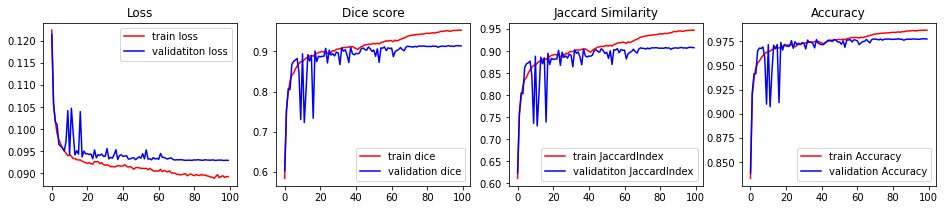

In [22]:
result_file_path = f"{config['model']['save_dir']}/result.json"
with open(result_file_path, 'r') as f:
    results = json.loads(''.join(f.readlines()))
epochs_info = results['epochs_info']

tr_losses = [d['tr_loss'] for d in epochs_info]
vl_losses = [d['vl_loss'] for d in epochs_info]
tr_dice = [d['tr_metrics']['train_metrics/Dice'] for d in epochs_info]
vl_dice = [d['vl_metrics']['valid_metrics/Dice'] for d in epochs_info]
tr_js = [d['tr_metrics']['train_metrics/MulticlassJaccardIndex'] for d in epochs_info]
vl_js = [d['vl_metrics']['valid_metrics/MulticlassJaccardIndex'] for d in epochs_info]
tr_acc = [d['tr_metrics']['train_metrics/MulticlassAccuracy'] for d in epochs_info]
vl_acc = [d['vl_metrics']['valid_metrics/MulticlassAccuracy'] for d in epochs_info]


_, axs = plt.subplots(1, 4, figsize=[16,3])

axs[0].set_title("Loss")
axs[0].plot(tr_losses, 'r-', label="train loss")
axs[0].plot(vl_losses, 'b-', label="validatiton loss")
axs[0].legend()

axs[1].set_title("Dice score")
axs[1].plot(tr_dice, 'r-', label="train dice")
axs[1].plot(vl_dice, 'b-', label="validation dice")
axs[1].legend()

axs[2].set_title("Jaccard Similarity")
axs[2].plot(tr_js, 'r-', label="train JaccardIndex")
axs[2].plot(vl_js, 'b-', label="validatiton JaccardIndex")
axs[2].legend()

axs[3].set_title("Accuracy")
axs[3].plot(tr_acc, 'r-', label="train Accuracy")
axs[3].plot(vl_acc, 'b-', label="validation Accuracy")
axs[3].legend()

plt.show()

In [23]:
from PIL import Image
import cv2
def skin_plot(img, gt, pred):
    img = np.array(img)
    gt = np.array(gt)
    pred = np.array(pred)
    edged_test = cv2.Canny(pred, 100, 255)
    contours_test, _ = cv2.findContours(edged_test, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    edged_gt = cv2.Canny(gt, 100, 255)
    contours_gt, _ = cv2.findContours(edged_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt_test in contours_test:
        cv2.drawContours(img, [cnt_test], -1, (0, 0, 255), 1)
    for cnt_gt in contours_gt:
        cv2.drawContours(img, [cnt_gt], -1, (0,255,0), 1)
    return img

#---------------------------------------------------------------------------------------------


save_imgs_dir = f"{config['model']['save_dir']}/visualized"

if not os.path.isdir(save_imgs_dir):
    os.mkdir(save_imgs_dir)

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        imgs = batch['image']
        msks = batch['mask']
        ids = batch['id']
        
        preds = best_model(imgs.to(device))
        
        txm = imgs.cpu().numpy()
        tbm = torch.argmax(msks, 1).cpu().numpy()
        tpm = torch.argmax(preds, 1).cpu().numpy()
        tid = ids
        
        for idx in range(len(tbm)):
            img = np.moveaxis(txm[idx, :3], 0, -1)*255.
            img = np.ascontiguousarray(img, dtype=np.uint8)
            gt = np.uint8(tbm[idx]*255.)
            pred = np.where(tpm[idx]>0.5, 255, 0)
            pred = np.ascontiguousarray(pred, dtype=np.uint8)
            
            res_img = skin_plot(img, gt, pred)
            
            fid = tid[idx]
            Image.fromarray(img).save(f"{save_imgs_dir}/{fid}_img.png")
            Image.fromarray(res_img).save(f"{save_imgs_dir}/{fid}_img_gt_pred.png")


100%|██████████| 68/68 [00:15<00:00,  4.27it/s]
